In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%pip install torch-geometric

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
/kaggle/input/google-sheets-api/crop-yield-prediction-452008-05e1862c508c.json
/kaggle/input/gyga-uganda-supervised/GygaModelRunsUganda - Rainfed maize model runs.csv
/kaggle/input/gyga-uganda-supervised/GygaUganda - Station.csv


In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import csv
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import metrics


Epoch 0, Loss: 1.6142510175704956
Epoch 10, Loss: 0.81618732213974
Epoch 20, Loss: 0.4887735843658447
Epoch 30, Loss: 0.361056923866272
Epoch 40, Loss: 0.3355371057987213
Epoch 50, Loss: 0.3299811780452728
Epoch 60, Loss: 0.224757581949234
Epoch 70, Loss: 0.18746578693389893
Epoch 80, Loss: 0.18861189484596252
Epoch 90, Loss: 0.22296425700187683
RMSE: 0.4577, MAE: 0.3808
Mean Percentage Error: 27.89%
Results saved to model_results_regression.csv
Learning Rate: 0.001, Mean Percentage Error: 27.89%


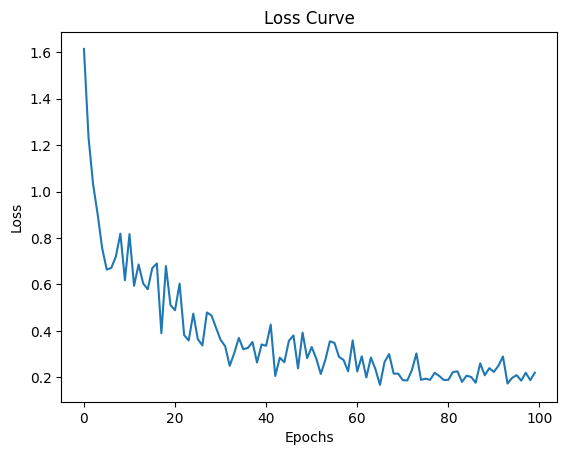

Epoch 0, Loss: 1.4606146812438965
Epoch 10, Loss: 0.5550373196601868
Epoch 20, Loss: 0.32467830181121826
Epoch 30, Loss: 0.19578129053115845
Epoch 40, Loss: 0.30552029609680176
Epoch 50, Loss: 0.29097217321395874
Epoch 60, Loss: 0.2525956630706787
Epoch 70, Loss: 0.21943774819374084
Epoch 80, Loss: 0.17613105475902557
Epoch 90, Loss: 0.19127069413661957
RMSE: 0.4092, MAE: 0.3418
Mean Percentage Error: 25.69%
Results saved to model_results_regression.csv
Learning Rate: 0.0005, Mean Percentage Error: 25.69%


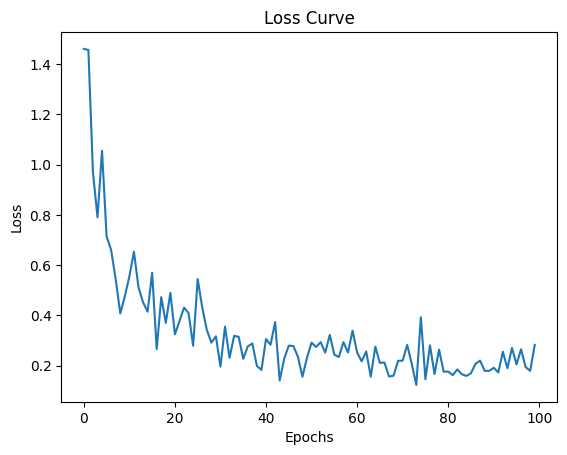

Epoch 0, Loss: 2.1340935230255127
Epoch 10, Loss: 1.844072937965393
Epoch 20, Loss: 1.4032994508743286
Epoch 30, Loss: 1.1815942525863647
Epoch 40, Loss: 1.130473256111145
Epoch 50, Loss: 0.8175344467163086
Epoch 60, Loss: 0.7024888396263123
Epoch 70, Loss: 0.7019562721252441
Epoch 80, Loss: 0.6597992777824402
Epoch 90, Loss: 0.6148579120635986
RMSE: 0.6577, MAE: 0.5393
Mean Percentage Error: 40.58%
Results saved to model_results_regression.csv
Learning Rate: 0.0001, Mean Percentage Error: 40.58%


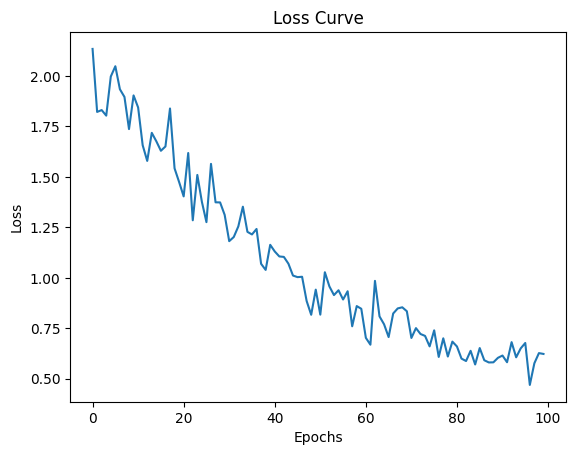

Results appended to Google Sheet.


In [11]:

import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv  # Use SAGEConv for SGAT-like behavior
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os
import csv
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from google.oauth2 import service_account
from googleapiclient.discovery import build

# 1. Data Preparation
# Load data
df = pd.read_csv("/kaggle/input/gyga-uganda-supervised/GygaUganda - Station.csv")

# Select features and target
target_variable = "YA"
numerical_features = ["CLIMATEZONE", "LATITUDE", "LONGITUDE"]
categorical_features = []

X = df[numerical_features]
y = df[target_variable]
y_tensor = torch.tensor(y.values, dtype=torch.float).view(-1, 1)

# Preprocessing
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)])

X_transformed = preprocessor.fit_transform(X)
x_tensor = torch.tensor(X_transformed, dtype=torch.float)

# Create KNN edges
def create_knn_edges(df, k=5):
    coords = df[['LONGITUDE', 'LATITUDE']].values
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(coords)
    distances, neighbor_indices = knn.kneighbors(coords)
    edge_index = []
    for i, neighbors in enumerate(neighbor_indices):
        for j in neighbors:
            edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t()

data = Data(x=x_tensor, y=y_tensor, edge_index=create_knn_edges(df))

# Train/test split (split indices)
train_indices, test_indices = train_test_split(
    torch.arange(data.num_nodes),
    test_size=0.2,
    random_state=42,
)

# Create train and test Data objects
train_data = data.subgraph(train_indices)
test_data = data.subgraph(test_indices)

# 2. SGAT Regression Model (using SAGEConv)
class SGATRegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(SGATRegression, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.regressor = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.regressor(x)
        return x

# Model initialization
in_channels = data.x.shape[1]
hidden_channels = 64
out_channels = 32
learning_rates = [0.001, 0.0005, 0.0001]
for lr in learning_rates:
    model = SGATRegression(in_channels, hidden_channels, out_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = F.mse_loss
    loss_values = []
    start_time = time.time()
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        y_pred = model(train_data.x, train_data.edge_index)
        loss = loss_fn(y_pred, train_data.y)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    end_time = time.time()
    training_time = end_time - start_time

    # 4. Model Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(test_data.x, test_data.edge_index)
        rmse = mean_squared_error(test_data.y.numpy(), y_pred_test.numpy(), squared=False)
        mae = mean_absolute_error(test_data.y.numpy(), y_pred_test.numpy())
        print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

        # Calculate percentage error
        actual_values = test_data.y.numpy().flatten()
        predicted_values = y_pred_test.numpy().flatten()
        percentage_errors = np.abs((predicted_values - actual_values) / actual_values) * 100
        mean_percentage_error = np.mean(percentage_errors)
        print(f'Mean Percentage Error: {mean_percentage_error:.2f}%')

        # Save results to CSV
        results = {
            "RMSE": rmse,
            "MAE": mae,
            "Mean Percentage Error": mean_percentage_error,
        }

        file_exists = False
        try:
            with open("prabability_results.csv", "r") as f:
                file_exists = True
        except FileNotFoundError:
            pass

        with open("prabability_results.csv", "a", newline="") as csvfile:
            fieldnames = ["RMSE", "MAE", "Mean Percentage Error"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if not file_exists:
                writer.writeheader()
            writer.writerow(results)

        print("Results saved to model_results_regression.csv")

        print(f"Learning Rate: {lr}, Mean Percentage Error: {mean_percentage_error:.2f}%")

    plt.plot(loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

    # Google Sheets Integration
    SERVICE_ACCOUNT_FILE = '/kaggle/input/google-sheets-api/crop-yield-prediction-452008-05e1862c508c.json'
    SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
    SPREADSHEET_ID = '143Gaf6z2s2hSIWjMZXw6snPuUPSZ6WViYZKmagmCzho'
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()

    # Prepare results for Google Sheets
    google_results = {
    "Model Name": "SGAT Regression (YA Prediction)",
    "Training Time(seconds)": training_time,
    "Epoch": epoch,
    "Loss": float(loss.item()),  # Convert to standard Python float
    "Mean Percentage Error": float(mean_percentage_error),  # Convert to standard Python float
    "Final Accuracy": float(100 - mean_percentage_error),  # Convert to standard Python float
    "Learning Rate": lr,
     }
    # Get the next available row
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range="Sheet6!A1:A").execute()
    num_rows = len(result.get('values', [])) + 1

    values = [
        [
            google_results["Model Name"],
            google_results["Training Time(seconds)"],
            google_results["Epoch"],
            google_results["Loss"],
            google_results["Mean Percentage Error"],
            f"{google_results['Final Accuracy']:.2f}%",
            google_results["Learning Rate"],
        ]
    ]


body = {'values': values}
sheet.values().append(spreadsheetId=SPREADSHEET_ID, range=f"Sheet6!A{num_rows}", valueInputOption="USER_ENTERED", body=body).execute()

print("Results appended to Google Sheet.")